## Data Cleaning

This data is scrapped and very messy. It does not come with a dictionary and I do not have access to the code that generated it to provide any insight about the variables gathered.

These data were scrapped in September 2020 and is provided in .CSV format. In this notebook I will only be cleaning up the data and saving in in parquet format which is more efficent for large datasets.

I will focus on creating a function that can be applied to the data so that it could become part of a pipeline and produce repeatable, scaleable results.

---
#### Imports and defined functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dask import delayed
from dask.distributed import Client, progress
import dask.array as da
import dask.dataframe as dd
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.3f}'.format

In [2]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
def print_nulls(ddf):
    out = ddf.isnull().sum()*100/ddf.isnull().isnull().count()
    
    return print_full(out.compute())

In [3]:
def plot_hist_boxplot(df):
    '''
    Accepts only numerical columns;
    use a maks.
    '''
    dim = df.shape[1]
    plt.figure(figsize=(20, dim*5))
    
    # iterate through the columns
    for i, column in enumerate(df.columns):
        
        # plot a histogram
        plt.subplot(dim, 2, (i+1)*2-1)
        plt.hist(df[column])
        plt.ylabel(column, size='xx-large')
        
        # plot a boxplot
        plt.subplot(dim, 2, (i+1)*2)
        plt.boxplot(df[column], whis=[2.5, 97.5]) # boxplot will show outliers beyond the inner 90th percentile
    plt.show()

In [4]:
client = Client(n_workers=4, threads_per_worker=2, memory_limit='3GB')
client

Client Scheduler: tcp://127.0.0.1:36963 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 12.00 GB


In [5]:
# read the first 10,000 rows in pandas to do understand the data structure
df = pd.read_csv(r'/home/owen/Jupyter/Capstone 4: Final Capstone/used_cars_data.csv', nrows=100000)

In [6]:
dtypes = {col : df[col].dtype for col in df.columns}

In [7]:
# These are retyped because they are being dropped
dtypes['sp_id'] = 'O'
dtypes['seller_rating'] = 'O'
dtypes['vehicle_damage_category'] = 'O'
dtypes['is_certified'] = 'O'
dtypes['combine_fuel_economy'] = 'O'
dtypes['listing_id'] = 'O'
dtypes['savings_amount'] = 'O'



# This contains problem values probably 4 digit codes
dtypes['dealer_zip'] = 'O'


In [8]:
# Load the data into Dask using the type map

df = dd.from_pandas(df, npartitions=5)

#df = dd.read_csv('/home/owen/Jupyter/Final/used_cars_data.csv', dtype=dtypes)

# It may also be useful here to apply dask's ability to read in only certain columns. 
# However for now I will deal with those by dropping them during cleaning.

##### Note about vehicle history 
In this version of the model I will be retaining only the rows with history information. Although I have some hope that this model could be generalize I'm going to limit my assumptions for the first pass.

In [ ]:

def clean(df):
    # create dataframe meta information to pass to map_partitions and apply
    meta = dd.utils.make_meta(df)
    
    #First Drop Duplicates
    df = df.drop_duplicates(subset='vin')

    # Limit the model to vehicles with NHTSA data available
    df = df[df['year'] > 1984]
    
    
    
    

In [9]:
print_nulls(df)

vin                         0.000
back_legroom                4.954
bed                        99.393
bed_height                 91.877
bed_length                 91.877
body_type                   0.401
cabin                      98.333
city                        0.000
city_fuel_economy          16.016
combine_fuel_economy      100.000
daysonmarket                0.000
dealer_zip                  0.000
description                 2.543
engine_cylinders            2.998
engine_displacement         5.339
engine_type                 2.998
exterior_color              0.000
fleet                      43.075
frame_damaged              43.075
franchise_dealer            0.000
franchise_make             25.416
front_legroom               4.954
fuel_tank_volume            4.954
fuel_type                   2.459
has_accidents              43.075
height                      4.954
highway_fuel_economy       16.016
horsepower                  5.339
interior_color              0.000
isCab         

In [10]:
### Operations to clean the dataset
'''
Retain only some of the featuers.
Many contain redundant information or information that I am not using on this pass.
In particular I am not using location data on this pass. 
'''

df = df.dropna(subset=['fleet'
, 'frame_damaged'
, 'isCab'
, 'has_accidents'
, 'salvage'
, 'theft_title'])

#First Drop Duplicates
df = df.drop_duplicates(subset='vin')

# Limit the model to vehicles with NHTSA data available
df = df[df['year'] > 1984]




# Retain the columns first to reduce memory footprint
kept = ['vin' 
        , 'make_name' # Use make and body type instead of model
        #, 'model_name'
        , 'body_type'
        , 'year'
        , 'engine_type' # This contains the number of cylnders as well as their configureation.   
        , 'wheel_system'
        , 'transmission'
        #, 'trimId'
        #, 'trim_name'
        , 'horsepower'
        , 'maximum_seating'
        , 'mileage'
        
        
        # Target Variable
        , 'price'

        # Fuel Economy Variables
        , 'fuel_type'  
        , 'city_fuel_economy'
        , 'highway_fuel_economy'
        , 'combine_fuel_economy'

        , 'daysonmarket'
        , 'franchise_dealer'
        , 'is_cpo'
        
        # These Features would need NLP
        , 'description'
        , 'major_options'
        , 'exterior_color'
        , 'interior_color'

        # Have cleaning method but probably not necessary
        , 'front_legroom'
        , 'back_legroom'

        # Vehicle History Features
        , 'owner_count'
        , 'has_accidents'       
        , 'salvage'
        , 'theft_title'
        , 'fleet'
        , 'frame_damaged'
        , 'isCab' # Guessing this indicates that it was used for ridesharing?
       ]

df = df.loc[:, kept].copy()

# Use vin as index?
'''
May additionally need to add a vin checker here
'''
df = df.set_index('vin')


df.persist()

# Generate a make/model/yearname column?
    # Would be most helpful if/when I merge outside data.
    # Dictionary of these and each has its own model?
        # Is that just LIFT?
    
# Drop almost half the dataset because it is missing history?, Drop those features?
'''
In this pass I'm going to retain these columns and shrink the data. 
There is still more than enough and this way I may be able to create a classifier to
recommend if purchasing history will be worth it or not.


['fleet'
, 'frame_damaged'
, 'isCab'
, 'has_accidents'
, 'salvage'
, 'theft_title']

'''

# Color and Description both need to be parsed
'''
Just dropping them in this pass. Added to the drop below
'''    


# Define a function to retype columns with unit inches
def strip_inches(t):
    try:
        t = float(str(t).strip(' in'))
        return t
    except:
        return np.nan

cols = ['back_legroom', 'front_legroom']
    
for col in cols:
    df[col] = df[col].apply(strip_inches, meta=(col, 'int64'))
    

# Clean and retype seating capacity 
def fix_seating(r):
    try:
        r = int(str(r).strip(' seats'))
        return r
    except:
        return np.nan
    
df['maximum_seating'] = df['maximum_seating'].apply(fix_seating, meta=
                                                    ('maximum_seating', 'int64')).compute()


# Clean up boolean columns into numerical
df['is_cpo'] = df['is_cpo'].apply(lambda x: 1 if x == True else 0)

df['franchise_dealer'] = df['franchise_dealer'].apply(lambda x: 1 if x == True else 0)

df['fleet'] = df['fleet'].apply(lambda x: 1 if x == True else 0)

df['frame_damaged'] = df['frame_damaged'].apply(lambda x: 1 if x == True else 0)

df['isCab'] = df['isCab'].apply(lambda x: 1 if x == True else 0)

df['has_accidents'] = df['has_accidents'].apply(lambda x: 1 if x == True else 0)

df['salvage'] = df['salvage'].apply(lambda x: 1 if x == True else 0)

df['theft_title'] = df['theft_title'].apply(lambda x: 1 if x == True else 0)


# Decide what to do about fuel economy

    # EPA generates combined by weighting city 55% and highway 45%
df['combine_fuel_economy'] = df['city_fuel_economy']*0.55 + df['highway_fuel_economy']*0.45
    # Would be cool to see a model that encorporates a ratio as input?
    
    
    
# See if I can bin TrimID better
'''
Drop them in this pass
'''



# Drop some features
df = df.drop([ 'description'
              , 'major_options'
              , 'exterior_color'
              , 'interior_color'
             #, 'trimId'
             #, 'trim_name'
             ], axis=1).copy()


In [11]:
print_nulls(df)

make_name               0.000
body_type               0.069
year                    0.000
engine_type             1.836
wheel_system            2.709
transmission            0.841
horsepower              3.266
maximum_seating         3.329
mileage                 0.939
price                   0.000
fuel_type               1.551
city_fuel_economy      13.557
highway_fuel_economy   13.557
combine_fuel_economy   13.557
daysonmarket            0.000
franchise_dealer        0.000
is_cpo                  0.000
front_legroom           4.291
back_legroom            6.689
owner_count             4.553
has_accidents           0.000
salvage                 0.000
theft_title             0.000
fleet                   0.000
frame_damaged           0.000
isCab                   0.000
dtype: float64


In [12]:
df = df.dropna()

In [13]:
#plot_hist_boxplot(df.select_dtypes(include='number'))

In [14]:
# Apply a log transformation to price
df['price'] = np.log(df['price'])
df = df.categorize().compute()
de = DummyEncoder()
X = de.fit_transform(df)

In [15]:
scaler = StandardScaler()

In [16]:
#X = scaler.fit_transform(df.drop('price', axis=1))

In [17]:
y = X['price']
X = X.drop('price', axis=1)


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1312)


In [19]:
lrm = LinearRegression()

with joblib.parallel_backend('dask'):
    scores = cross_validate(lrm, X_train, y_train, cv=4)
    
scores

{'fit_time': array([0.56898165, 0.87254453, 1.12062526, 1.14587212]),
 'score_time': array([0.01296878, 0.01154304, 0.00735474, 0.00728607]),
 'test_score': array([0.91907079, 0.91876608, 0.91814035, 0.90511732])}

In [20]:
df

,make_name,body_type,year,engine_type,wheel_system,transmission,horsepower,maximum_seating,mileage,price,...,is_cpo,front_legroom,back_legroom,owner_count,has_accidents,salvage,theft_title,fleet,frame_damaged,isCab
vin,,,,,,,,,,,,,,,,,,,,,
19UDE2F30HA008509,Acura,Sedan,2017,I4,FWD,A,201.000,5.000,47370.000,9.433,...,0,42.300,34.000,2.000,0,0,0,0,0,0
19UDE2F30KA001602,Acura,Sedan,2019,I4,FWD,A,201.000,5.000,30022.000,10.043,...,1,42.300,34.000,1.000,0,0,0,0,0,0
19UDE2F31HA005487,Acura,Sedan,2017,I4,FWD,A,201.000,5.000,39195.000,9.540,...,0,42.300,34.000,2.000,1,0,0,0,0,0
19UDE2F31HA016411,Acura,Sedan,2017,I4,FWD,A,201.000,5.000,6184.000,9.883,...,0,42.300,34.000,1.000,0,0,0,0,0,0
19UDE2F32HA002209,Acura,Sedan,2017,I4,FWD,A,201.000,5.000,26184.000,9.868,...,0,42.300,34.000,1.000,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZFBCFYDB5HP537264,FIAT,SUV / Crossover,2017,I4,AWD,A,180.000,5.000,19348.000,9.740,...,0,41.400,34.800,1.000,0,0,0,0,0,0
ZFBCFYDT7GP511742,FIAT,SUV / Crossover,2016,I4,AWD,A,180.000,5.000,18497.000,9.729,...,0,41.400,34.800,1.000,0,0,0,0,0,0
ZFBCFYET3GP412978,FIAT,SUV / Crossover,2016,I4,AWD,A,180.000,5.000,34313.000,9.740,...,0,41.400,34.800,2.000,0,0,0,1,0,1


In [1]:
import numpy as np
np.exp(9.883)

19594.417828780388

In [21]:
# create masks for the columns by type
conts = df.select_dtypes(include='number').columns
cats = df.select_dtypes(exclude='number').columns

<AxesSubplot:>

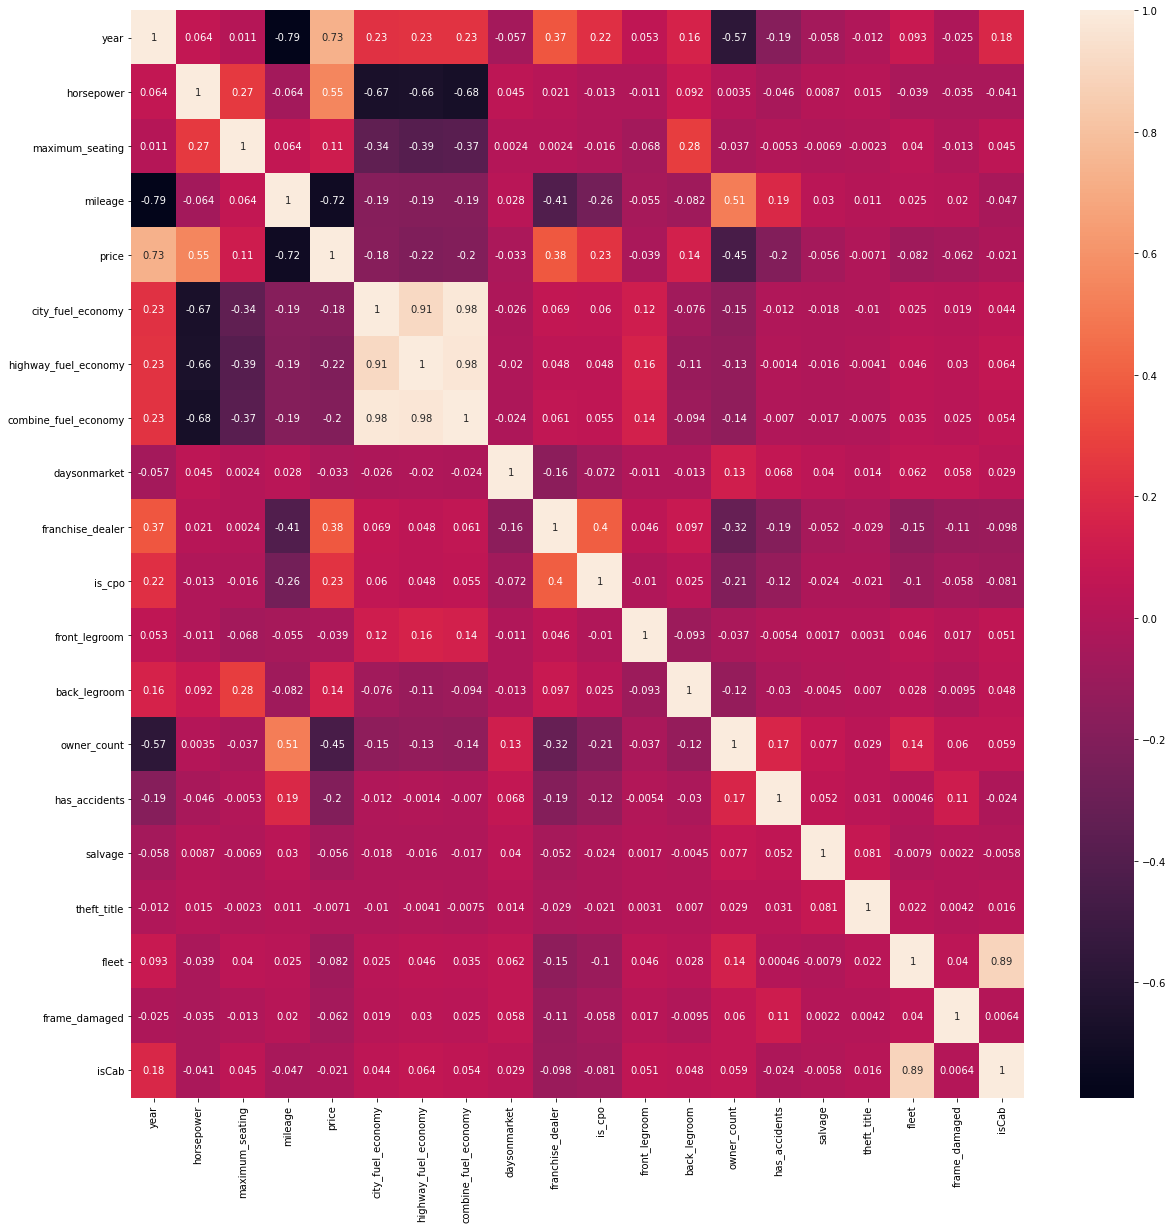

In [22]:
# Plot a heatmap of correlation
corr_map = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr_map, annot=True)

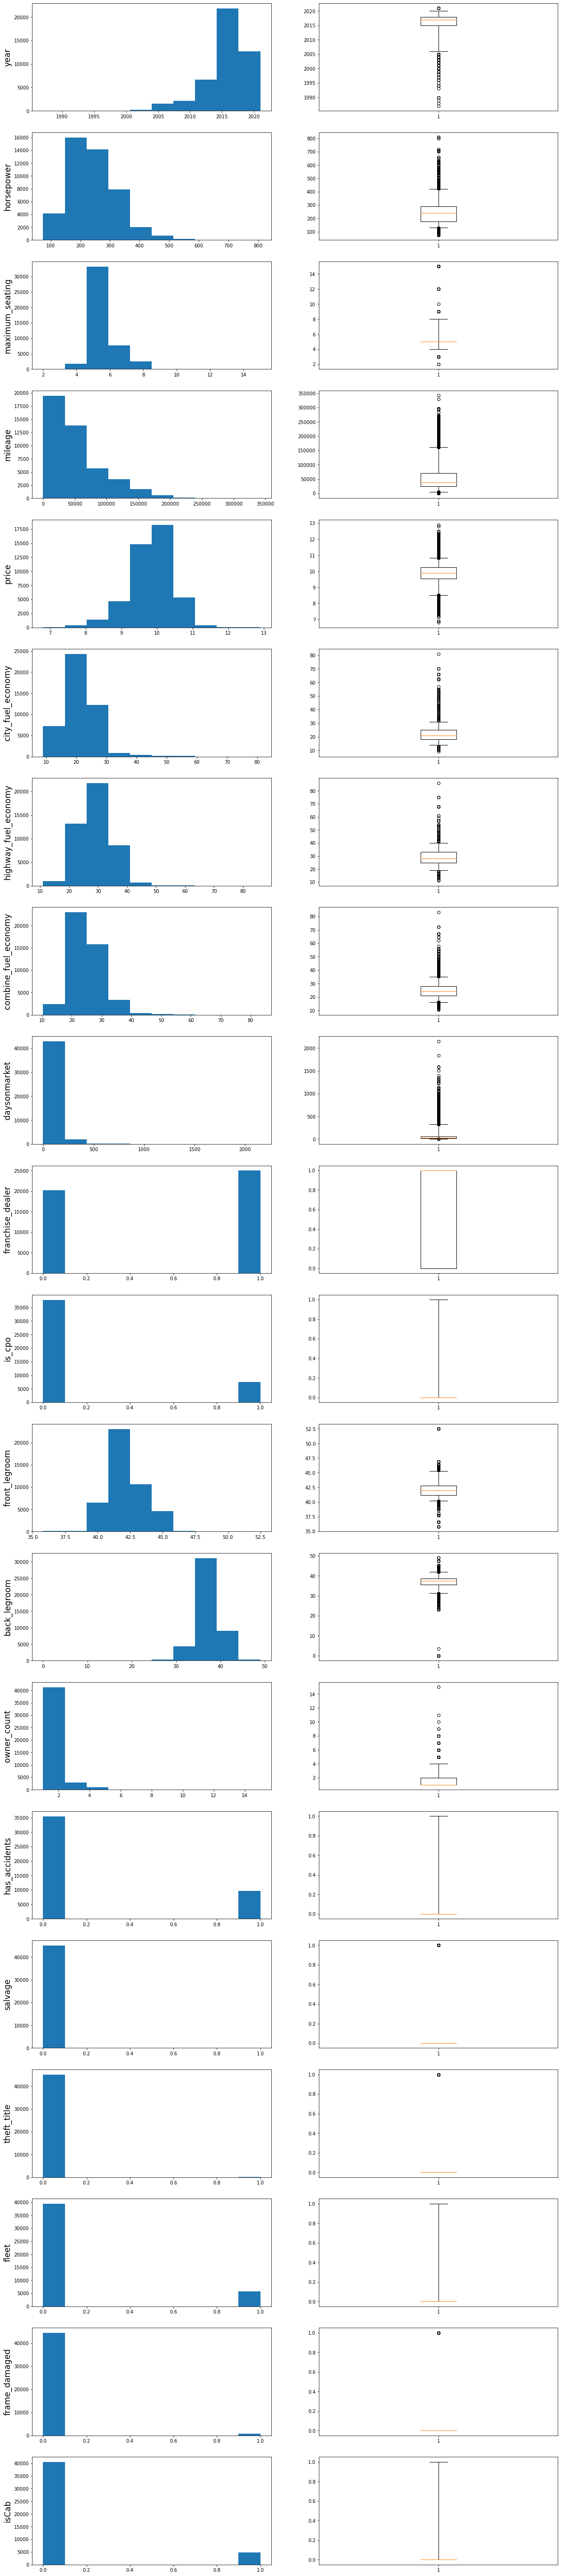

In [23]:
plot_hist_boxplot(df.select_dtypes(include='number'))

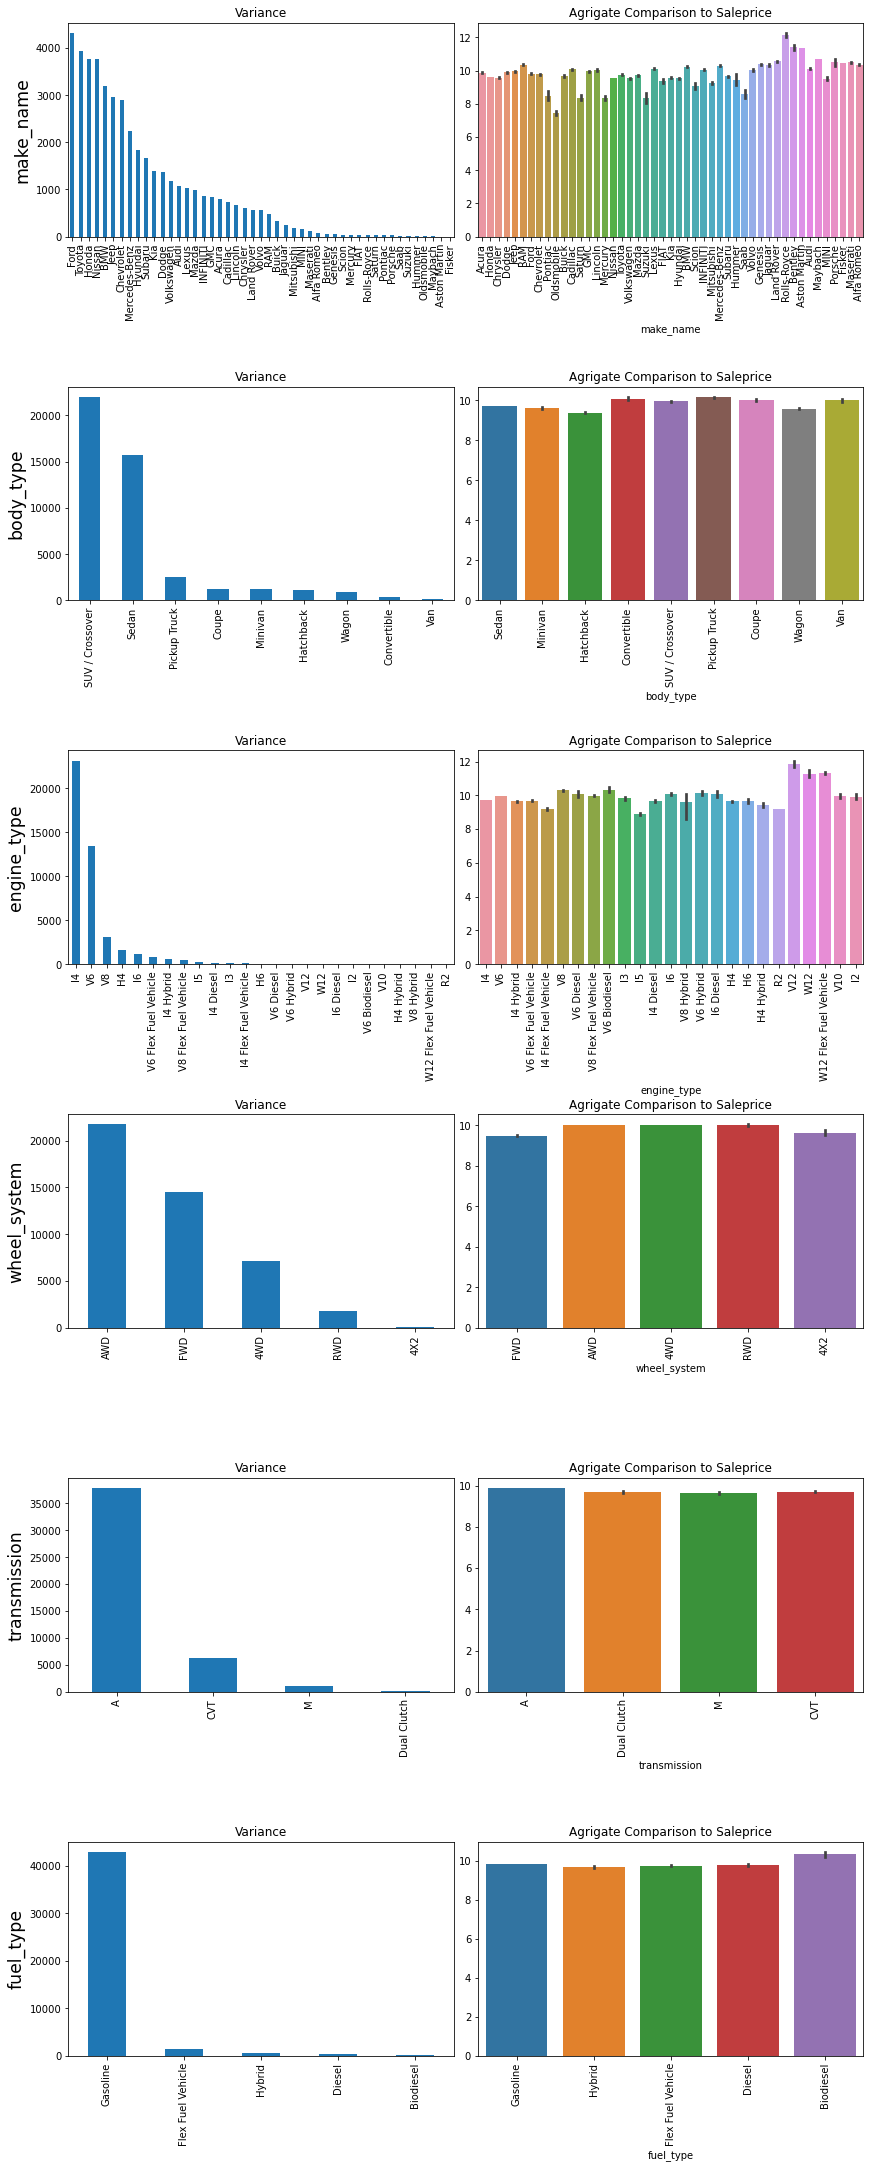

In [24]:
plt.figure(figsize=(12, len(cats)*5))
for i, feature in enumerate(cats):
    plt.subplot(len(cats), 2, (i+1)*2-1)
    df[feature].value_counts().plot(kind='bar')
    plt.ylabel(feature, size='xx-large')
    plt.title('Variance')
    plt.xlabel('')
    plt.xticks(rotation=90)
    
    
    plt.subplot(len(cats), 2, (i+1)*2)
    sns.barplot(x=df[feature], y=df['price'])
    plt.ylabel('')
    plt.title('Agrigate Comparison to Saleprice')
    plt.xticks(rotation=90)
plt.tight_layout(pad=0.3)
plt.show()

In [25]:
cats

Index(['make_name', 'body_type', 'engine_type', 'wheel_system', 'transmission',
       'fuel_type'],
      dtype='object')

In [27]:
df.columns

Index(['make_name', 'body_type', 'year', 'engine_type', 'wheel_system',
       'transmission', 'horsepower', 'maximum_seating', 'mileage', 'price',
       'fuel_type', 'city_fuel_economy', 'highway_fuel_economy',
       'combine_fuel_economy', 'daysonmarket', 'franchise_dealer', 'is_cpo',
       'front_legroom', 'back_legroom', 'owner_count', 'has_accidents',
       'salvage', 'theft_title', 'fleet', 'frame_damaged', 'isCab'],
      dtype='object')

In [72]:
# Limit the columns and get into pandas to explore a little

kept = ['make_name', 'body_type', 'year', 'mileage', 'price', 'daysonmarket', 'franchise_dealer', 'is_cpo'
 , 'owner_count', 'has_accidents', 'salvage', 'theft_title', 'fleet', 'frame_damaged', 'isCab']

df2 = df.loc[:, kept]

In [73]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 45206 entries, 19UDE2F30HA008509 to ZFBERFAT5G6B38640
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   make_name         45206 non-null  category
 1   body_type         45206 non-null  category
 2   year              45206 non-null  int64   
 3   mileage           45206 non-null  float64 
 4   price             45206 non-null  float64 
 5   daysonmarket      45206 non-null  int64   
 6   franchise_dealer  45206 non-null  int64   
 7   is_cpo            45206 non-null  int64   
 8   owner_count       45206 non-null  float64 
 9   has_accidents     45206 non-null  int64   
 10  salvage           45206 non-null  int64   
 11  theft_title       45206 non-null  int64   
 12  fleet             45206 non-null  int64   
 13  frame_damaged     45206 non-null  int64   
 14  isCab             45206 non-null  int64   
dtypes: category(2), float64(3), int64(10

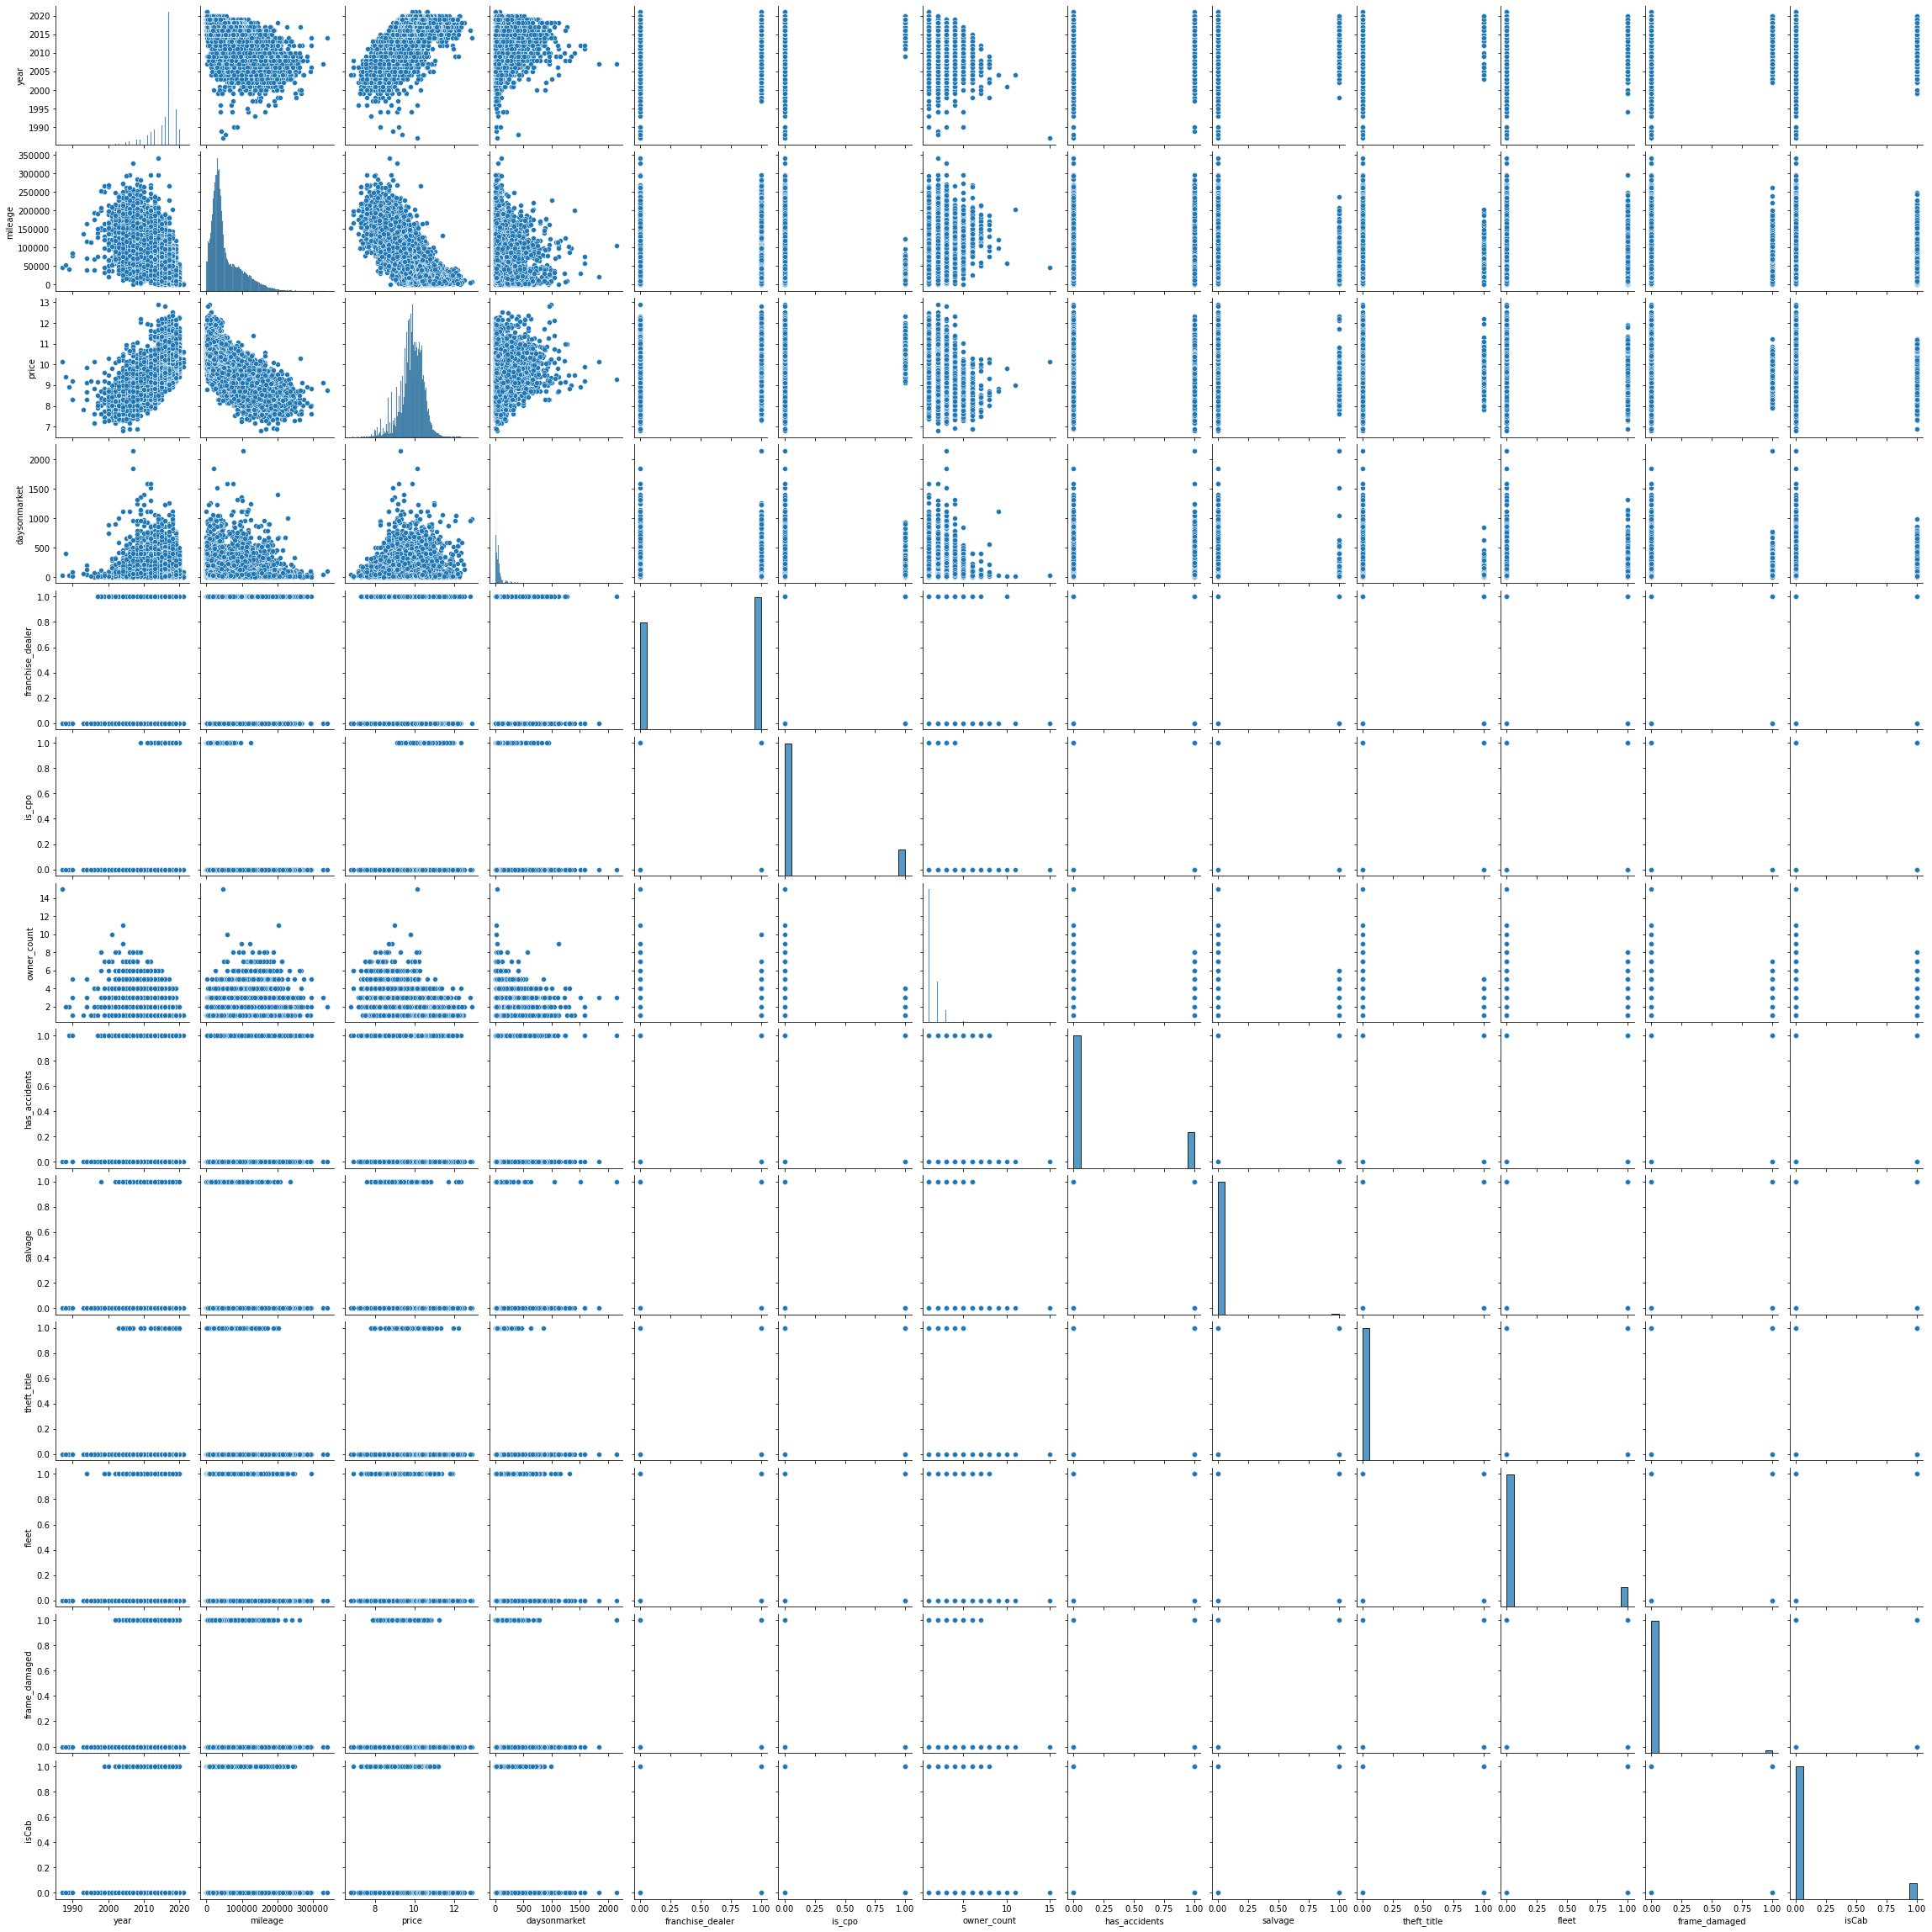

In [32]:
sns.pairplot(df2)

In [33]:
df2.describe()

,year,mileage,price,daysonmarket,franchise_dealer,is_cpo,owner_count,has_accidents,salvage,theft_title,fleet,frame_damaged,isCab
count,45206.000,45206.000,45206.000,45206.000,45206.000,45206.000,45206.000,45206.000,45206.000,45206.000,45206.000,45206.000,45206.000
mean,2015.788,52525.092,9.843,54.044,0.553,0.164,1.424,0.215,0.003,0.004,0.128,0.017,0.105
std,3.394,41666.555,0.590,89.180,0.497,0.370,0.776,0.411,0.055,0.067,0.334,0.128,0.307
min,1987.000,0.000,6.801,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2015.000,24604.000,9.546,13.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,2017.000,38026.000,9.890,28.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,2018.000,71499.750,10.240,55.000,1.000,0.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000
max,2021.000,341893.000,12.899,2150.000,1.000,1.000,15.000,1.000,1.000,1.000,1.000,1.000,1.000


In [ ]:
# Franchise dealsers are 

In [75]:
mask = (df2['has_accidents'] > 0) | (df2['salvage'] > 0) | (df2['theft_title'] > 0 ) | (df2['fleet'] > 0) | (df2['isCab'] > 0) | (df2['frame_damaged'] > 0)

In [76]:
mask.value_counts()

False    30556
True     14650
dtype: int64

In [77]:
df2.loc[mask, 'target'] = 1

In [78]:
df2.loc[:, 'target'] = df2['target'].fillna(0)

In [79]:
df2['target'].value_counts()

0.000    30556
1.000    14650
Name: target, dtype: int64

In [80]:
df2.drop(['has_accidents', 'salvage', 'theft_title', 'fleet', 'isCab', 'frame_damaged'], axis=1, inplace=True)

In [81]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 45206 entries, 19UDE2F30HA008509 to ZFBERFAT5G6B38640
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   make_name         45206 non-null  category
 1   body_type         45206 non-null  category
 2   year              45206 non-null  int64   
 3   mileage           45206 non-null  float64 
 4   price             45206 non-null  float64 
 5   daysonmarket      45206 non-null  int64   
 6   franchise_dealer  45206 non-null  int64   
 7   is_cpo            45206 non-null  int64   
 8   owner_count       45206 non-null  float64 
 9   target            45206 non-null  float64 
dtypes: category(2), float64(4), int64(4)
memory usage: 4.6 MB


In [82]:
df3 = de.fit_transform(df2)

In [58]:
from sklearn import model_selection

In [83]:
y = df3['target']
X = df3.drop('target', axis=1)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.25, random_state=1312) 

In [60]:
from sklearn.ensemble import RandomForestClassifier

In [84]:
rfc = RandomForestClassifier(n_estimators=200, max_depth=5)


with joblib.parallel_backend('dask'):
    scores = cross_validate(rfc, X_train, y_train, cv=4)

In [85]:
scores

{'fit_time': array([4.2600441 , 4.02403927, 4.5332377 , 2.91554713]),
 'score_time': array([0.1372869 , 0.15078831, 0.11022758, 0.29938436]),
 'test_score': array([0.68298726, 0.68640868, 0.68770647, 0.68227938])}

In [71]:
X.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 45206 entries, 19UDE2F30HA008509 to ZFBERFAT5G6B38640
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   year                       45206 non-null  int64  
 1   mileage                    45206 non-null  float64
 2   price                      45206 non-null  float64
 3   daysonmarket               45206 non-null  int64  
 4   franchise_dealer           45206 non-null  int64  
 5   is_cpo                     45206 non-null  int64  
 6   owner_count                45206 non-null  float64
 7   frame_damaged              45206 non-null  int64  
 8   make_name_Acura            45206 non-null  uint8  
 9   make_name_Honda            45206 non-null  uint8  
 10  make_name_Chrysler         45206 non-null  uint8  
 11  make_name_Dodge            45206 non-null  uint8  
 12  make_name_Jeep             45206 non-null  uint8  
 13  make_name_RA

In [86]:
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=200)

In [88]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [87]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score

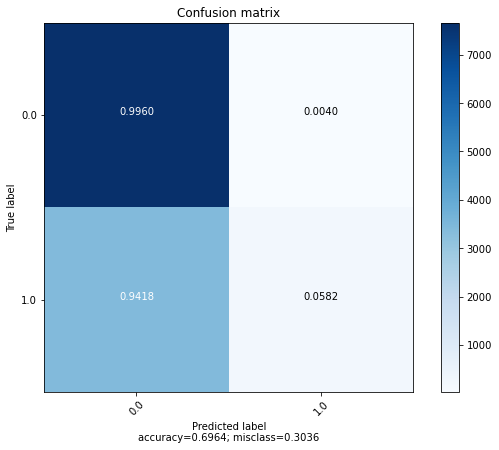

In [90]:
preds = rfc.predict(X_test)

confusion = confusion_matrix(y_test, preds)

plot_confusion_matrix(confusion, y.unique())

In [93]:
np.unique(preds, return_counts=True)

(array([0., 1.]), array([11061,   241]))